In [ ]:
pip install deepxde

In [2]:
#approximate upper bound of range
#right bound of domain (used for scaling)

ub = 200
rb = 20

Compiling model...
Building feed-forward neural network...
'build' took 0.109090 s



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.268876 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.86e+02, 1.11e+01]    [1.86e+02, 1.10e+01]    []  
1000      [1.28e+01, 4.29e-01]    [1.29e+01, 4.29e-01]    []  
2000      [4.39e+00, 6.31e-01]    [4.45e+00, 6.30e-01]    []  
3000      [2.95e+00, 6.29e-01]    [3.00e+00, 6.30e-01]    []  
4000      [2.19e+00, 6.57e-01]    [2.23e+00, 6.60e-01]    []  
5000      [1.58e+00, 6.56e-01]    [1.62e+00, 6.61e-01]    []  
6000      [1.14e+00, 5.92e-01]    [1.17e+00, 5.97e-01]    []  
7000      [7.66e-01, 4.82e-01]    [7.86e-01, 4.88e-01]    []  
8000      [5.26e-01, 3.47e-01]    [5.38e-01, 3.51e-01]    []  
9000      [3.23e-01, 2.66e-01]    [3.29e-01, 2.70e-01]    []  
10000     [1.79e-01, 2.52e-01]    [1.82e-01, 2.55e-01]    []  
11000     [1.22e-01, 1.75e-01]    [1.23e-01, 1.77e-01]    []  
12000     [8.77e-02, 1.47e-01]    [8.80e-02, 1.48e-01]    []  
13000     [9.82e-02, 1.20e-01]    [9.82

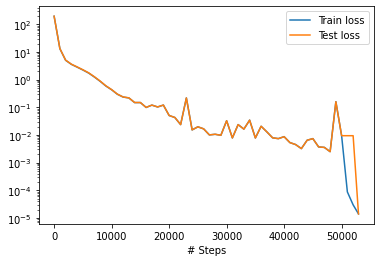

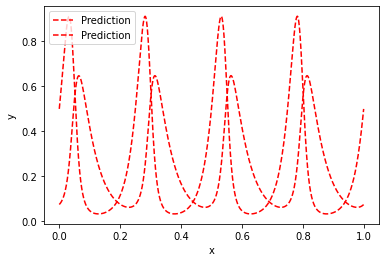

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

import deepxde as dde


def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]


def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0.0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, "sobol", num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)


def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )


# hard constraints: x(0) = 100, y(0) = 15
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]

    return tf.concat(
        (y1 * tf.math.tanh(t) + 100 / ub, y2 * tf.math.tanh(t) + 15 / ub), axis=1
    )


net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=50000)

model.compile("L-BFGS-B")
model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Predicting...
'predict' took 0.056191 s



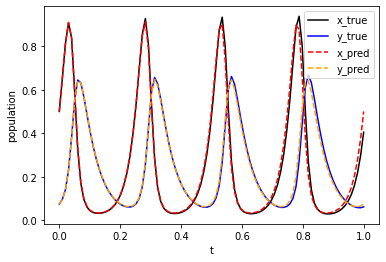

L2 relative error for x: 0.07900034904833673
L2 relative error for y: 0.053645113381912614


In [6]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


t = np.linspace(0, 1, 100)

sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
x_true, y_true = sol.y
x_true = x_true.reshape(100, 1)
y_true = y_true.reshape(100, 1)
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.xlabel("t")
plt.ylabel("population")
plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()


print("L2 relative error for x:", dde.metrics.l2_relative_error(x_true, x_pred))
print("L2 relative error for y:", dde.metrics.l2_relative_error(y_true, y_pred))
